In [ ]:
import numpy as np

eval_data_original = np.load("/content/drive/MyDrive/Colab Notebooks/eval_data_complete.npy")
eval_label_original = np.load("/content/drive/MyDrive/Colab Notebooks/eval_label_complete.npy")

In [ ]:
eval_data = eval_data_original[10:-50]
eval_label = eval_label_original[10:-50]

test_data = np.concatenate((eval_data_original[:10], eval_data_original[-50:]))
test_label = np.concatenate((eval_label_original[:10], eval_label_original[-50:]))

eval_data_original = 0
eval_label_original = 0

In [ ]:
print(np.count_nonzero(eval_label == 1))
print(np.count_nonzero(eval_label_original == 1))
print(np.count_nonzero(eval_label == 0))
print(np.count_nonzero(eval_label_original == 0))

337
0
1798
1


In [ ]:
abnormal_data = eval_data[:337]
abnormal_label = eval_label[:337]

In [ ]:
new_abnormal_data = np.concatenate((abnormal_data, abnormal_data, abnormal_data, abnormal_data))
new_abnormal_label = np.concatenate((abnormal_label, abnormal_label, abnormal_label, abnormal_label))

In [ ]:
print(new_abnormal_data.shape)
print(new_abnormal_label.shape)
print(new_abnormal_label[0])

(1348, 22, 15000)
(1348,)
1.0


In [ ]:
new_abnormal_data = 0

In [ ]:
eval_data = np.concatenate((eval_data[:337], eval_data[:337], eval_data[:337], eval_data[:337], eval_data))
eval_label = np.concatenate((eval_label[:337], eval_label[:337], eval_label[:337], eval_label[:337], eval_label))
print(eval_data.shape)
print(eval_label.shape)

(3483, 22, 15000)
(3483,)


In [ ]:
idx = np.random.permutation(len(eval_data))
eval_data,eval_label = eval_data[idx], eval_label[idx]

In [ ]:
from tensorflow.keras.utils import to_categorical

#enc_labels = to_categorical(eval_label, num_classes=2)              
#eval_label= enc_labels
print(eval_data.shape)
print(eval_label.shape)
print(eval_data.dtype)
print(eval_label.dtype)
print('training labels have been loaded')

bs,t,f = eval_data.shape

(3483, 22, 15000)
(3483,)
float32
float64
training labels have been loaded


In [ ]:
from pdb import set_trace
#import mne
import pandas as pd
import numpy as np
import math
import os
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN,LSTM, Dense, Activation, Bidirectional
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping


# ----------------------CHRONONET Testing-----------------------
from tensorflow.keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from tensorflow.keras.models import Model
inputsin= Input(shape=(t,f))
# ------------------First Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(inputsin)
tower1 = BatchNormalization()(tower1)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(inputsin)
tower2 = BatchNormalization()(tower2)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(inputsin)
tower3 = BatchNormalization()(tower3)
x = concatenate([tower1,tower2,tower3],axis=2)
x = Dropout(0.45)(x)

# ----------------------Second Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower1 = BatchNormalization()(tower1)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower2 = BatchNormalization()(tower2)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
tower3 = BatchNormalization()(tower3)
x = concatenate([tower1,tower2,tower3],axis=2)
x = Dropout(0.45)(x)

# ----------------------------------Third Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower1 = BatchNormalization()(tower1)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower2 = BatchNormalization()(tower2)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
tower3 = BatchNormalization()(tower3)
x = concatenate([tower1,tower2,tower3],axis=2)
x = Dropout(0.45)(x)

res1 = GRU(32,activation='tanh',return_sequences=True)(x)
res2 = GRU(32,activation='tanh',return_sequences=True)(res1)
res1_2 = concatenate([res1,res2],axis=2)
res3 = GRU(32,activation='tanh',return_sequences=True)(res1_2)
x = concatenate([res1,res2,res3])
x = GRU(32,activation='tanh')(x)

predictions = Dense(2,activation='softmax')(x)
model = Model(inputs=inputsin, outputs=predictions)

# learning rate to 0.00001
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

# learning rate to 0.0001
# adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)


model.compile(optimizer = adam_optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
print(model.metrics_names)
print(model.summary())

# early stopping
es = EarlyStopping(monitor='val_loss', min_delta=0.01, mode='min', verbose=1, patience=25)                          #patience
mc = ModelCheckpoint('model3flipped_acc.hdf5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)        #filepath (save model as)
mces = ModelCheckpoint('model3flipped_loss.hdf5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)      #filepath (save model as)

# fit model
# hist=model.fit(eval_data,eval_label,validation_split=0.2,epochs=1000,batch_size=128,verbose=1,callbacks=[es, mc,mces],shuffle=False) #epochs #split #

# fit model (without early stopping)
hist=model.fit(eval_data,eval_label,validation_split=0.2,epochs=200,batch_size=128,verbose=1,callbacks=[mc,mces],shuffle=False) #epochs #split #


print('The End')

[]
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 22, 15000)]  0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 11, 32)       960032      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 11, 32)       1920032     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 11, 32)       3840032     input_1[0][0]                    
___________________________________________________________________________________________

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.show()

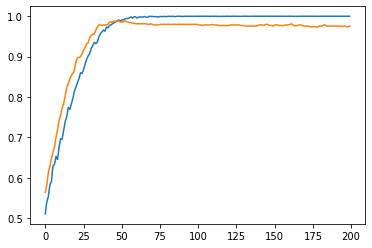

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.show()

In [ ]:
predictions = Dense(2,activation='softmax')(x)
model_2 = Model(inputs=inputsin, outputs=predictions)

model_2.load_weights("model3flipped_loss.hdf5")

In [ ]:
print(model.predict(test_data))
print(model_2.predict(test_data))

[[0.9611213  0.03887872]
 [0.9835639  0.01643612]
 [0.9113208  0.08867916]
 [0.9746353  0.02536466]
 [0.9837685  0.01623153]
 [0.9883259  0.01167403]
 [0.9874455  0.01255455]
 [0.87507534 0.12492462]
 [0.91678756 0.08321238]
 [0.98510784 0.01489211]
 [0.98812824 0.01187173]
 [0.98383015 0.0161698 ]
 [0.9738046  0.02619543]
 [0.98776114 0.01223886]
 [0.99205714 0.00794286]
 [0.9931606  0.00683935]
 [0.9900643  0.00993565]
 [0.34183866 0.6581613 ]
 [0.98040295 0.019597  ]
 [0.98928076 0.0107193 ]
 [0.99225265 0.0077474 ]
 [0.12902907 0.8709709 ]
 [0.990888   0.00911205]
 [0.9815787  0.01842131]
 [0.9592221  0.0407779 ]
 [0.9912416  0.00875836]
 [0.9899238  0.01007627]
 [0.97555    0.02445006]
 [0.9869932  0.01300688]
 [0.9918059  0.00819405]
 [0.99321824 0.0067818 ]
 [0.99446636 0.00553369]
 [0.4218575  0.57814246]
 [0.98154116 0.01845884]
 [0.9924177  0.00758231]
 [0.9785695  0.02143054]
 [0.9809911  0.01900891]
 [0.9940918  0.00590816]
 [0.95619655 0.04380351]
 [0.98146445 0.01853553]


In [ ]:
results = model_2.predict(test_data)

In [ ]:
res = []
for result in results:
  if result[0] > result[1]:
    res.append([0, 1])
  else:
    res.append([1, 0])

In [ ]:
corr = 0
for i in range(len(test_label)):
  #print(int(test_label[i]), res[i])
  if res[i][int(test_label[i])] == 1:
    #print('yes')
    corr += 1
print(corr)

41


In [ ]:
np.min(results[:10], axis=0)

array([0.8633166 , 0.01507833], dtype=float32)

#Compressed Shallow Net

In [ ]:
!pip install brevitas

     |████████████████████████████████| 348kB 8.3MB/s 


In [ ]:
import torch
from torch import nn
from torch.nn import Module
import torch.nn.functional as F

import brevitas.nn as qnn

class Shallow_Net(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv1 = qnn.QuantConv1d(22, 40, 25, weight_bit_width=4)
    self.relu1 = nn.ReLU()

    x = torch.randn(22, 15000).view(-1, 22, 15000)
    self._to_linear = None
    self.convs(x)

    self.fc1 = qnn.QuantLinear(self._to_linear, 2, bias=False, weight_bit_width=4)

  def convs(self, x):
    x = F.avg_pool1d(F.relu(self.conv1(x)), 2)

    if self._to_linear == None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]
    return x

  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self._to_linear)
    x = self.fc1(x)

    #return F.softmax(x, dim=1)
    return x


shallow_net = Shallow_Net()
#print(test_net)

'''
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("running on the gpu")
else:
  device = torch.device("cpu")
  print("running on the CPU")

shallow_net.to(device)
'''



No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


'\nif torch.cuda.is_available():\n  device = torch.device("cuda:0")\n  print("running on the gpu")\nelse:\n  device = torch.device("cpu")\n  print("running on the CPU")\n\nshallow_net.to(device)\n'

In [ ]:
eval_data = torch.Tensor(eval_data)
eval_label = torch.Tensor(eval_label)

VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(eval_data)*VAL_PCT)
#print(val_size)

train_X = eval_data[:-val_size]
train_y = eval_label[:-val_size]

test_X = eval_data[-val_size:]
test_y = eval_label[-val_size:]

eval_data = 0
eval_label = 0

print(len(train_X))
print(len(test_X))

3135
348


In [ ]:
train_y.long()

tensor([0, 1, 0,  ..., 0, 0, 1])

In [ ]:
import torch.optim as optim
from tqdm import tqdm


optimizer = optim.Adam(shallow_net.parameters(), lr=0.00005)
loss_function = nn.CrossEntropyLoss()
#loss_function = CategoricalCrossEntropyLoss()
#loss_function = nn.sparse_categorical_crossentropy()

def fwd_pass(X, y, train=False):
  if train:
    shallow_net.zero_grad()
  outputs = shallow_net(X)
  #outputs = torch.Tensor(outputs).long()
  print(outputs, y)
  matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs, y)]
  acc = matches.count(True)/len(matches)
  loss = loss_function(outputs, y.long())

  if train:
    loss.backward()
    optimizer.step()
  return acc, loss

import numpy as np

def test(size=32):  
  random_start = np.random.randint(len(test_X) - size)
  X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
  with torch.no_grad():
    val_acc, val_loss = fwd_pass(X.view(-1, 22, 15000), y)
  return val_acc, val_loss

val_acc, val_loss = test(size=32)
print(val_acc, val_loss)


import time

MODEL_NAME = f"model-{int(time.time())}"


print(MODEL_NAME)

def train():
  BATCH_SIZE = 132
  EPOCHS = 50

  with open("model.log", "a") as f:
    for epoch in range(EPOCHS):
      for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 22, 15000)
        batch_y = train_y[i:i+BATCH_SIZE]

        acc, loss = fwd_pass(batch_X, batch_y, train=True)
        
        # every 50 steps 
        if i % 50 == 0:
          val_acc, val_loss = test(size=132)
          f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc), 2)}, {round(float(loss), 4)},{round(float(val_acc), 2)}, {round(float(val_loss), 4)}\n")

train()

  0%|          | 0/24 [00:00<?, ?it/s]

0.3125 tensor(0.7059)
model-1619005505


100%|██████████| 24/24 [02:24<00:00,  6.02s/it]


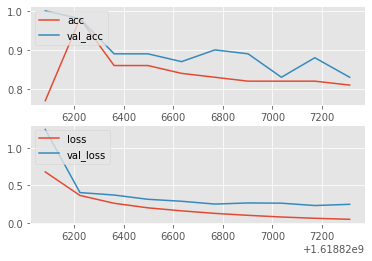

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

def create_acc_loss_graph(model_name):
  contents = open("model.log", "r").read().split('\n')

  times = []
  accs = []
  losses = []

  val_accs = []
  val_losses = []

  for c in contents:
    if model_name in c:      
      name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
      times.append(float(timestamp))
      accs.append(float(acc))
      losses.append(float(loss))
      val_accs.append(float(val_acc))
      val_losses.append(float(val_loss))


  fig = plt.figure()

  ax1 = plt.subplot2grid((2,1),(0,0))
  ax2 = plt.subplot2grid((2,1),(1,0), sharex=ax1)

  ax1.plot(times, accs, label="acc")
  ax1.plot(times, val_accs, label="val_acc")
  ax1.legend(loc=2)

  ax2.plot(times, losses, label="loss")
  ax2.plot(times, val_losses, label="val_loss")
  ax2.legend(loc=2)

  plt.show()

create_acc_loss_graph(MODEL_NAME)
      
      


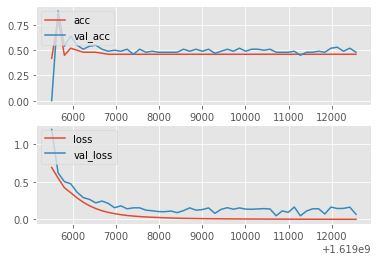

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

def create_acc_loss_graph(model_name):
  contents = open("model.log", "r").read().split('\n')

  times = []
  accs = []
  losses = []

  val_accs = []
  val_losses = []

  for c in contents:
    if model_name in c:      
      name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
      times.append(float(timestamp))
      accs.append(float(acc))
      losses.append(float(loss))
      val_accs.append(float(val_acc))
      val_losses.append(float(val_loss))


  fig = plt.figure()

  ax1 = plt.subplot2grid((2,1),(0,0))
  ax2 = plt.subplot2grid((2,1),(1,0), sharex=ax1)

  ax1.plot(times, accs, label="acc")
  ax1.plot(times, val_accs, label="val_acc")
  ax1.legend(loc=2)

  ax2.plot(times, losses, label="loss")
  ax2.plot(times, val_losses, label="val_loss")
  ax2.legend(loc=2)

  plt.show()

create_acc_loss_graph(MODEL_NAME)
      
      


In [ ]:
def fwd_pass(X, y, train=False):
  if train:
    shallow_net.zero_grad()
  outputs = shallow_net(X)
  #outputs = torch.Tensor(outputs).long()
  print(outputs, y)
  matches = [torch.argmax(i) == j for i,j in zip(outputs, y)]
  acc = matches.count(True)/len(matches)
  loss = loss_function(outputs, y.long())

  if train:
    loss.backward()
    optimizer.step()
  return acc, loss

import numpy as np

def test(size=32):  
  random_start = np.random.randint(len(test_X) - size)
  X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
  with torch.no_grad():
    val_acc, val_loss = fwd_pass(X.view(-1, 22, 15000), y)
  return val_acc, val_loss

val_acc, val_loss = test(size=32)
print(val_acc, val_loss)

print(test(size=32))

tensor([[ -3.2791,   3.1672],
        [  3.2942,  -3.2428],
        [  3.7096,  -3.7376],
        [ -2.4541,   3.0385],
        [  2.1977,  -2.1593],
        [  6.7198,  -6.6206],
        [ -2.0867,   2.1740],
        [  3.5615,  -3.4206],
        [ -2.8189,   2.7732],
        [  3.3797,  -3.4408],
        [  2.8963,  -2.8145],
        [  1.7005,  -1.8947],
        [  3.6573,  -3.5421],
        [ -0.4252,   1.1114],
        [ -2.9450,   3.0754],
        [ -2.7821,   2.6404],
        [ -3.8411,   3.6535],
        [ -4.0204,   3.6121],
        [ 11.2385, -10.9259],
        [  1.9413,  -1.7180],
        [ -2.8283,   3.1129],
        [ -3.1749,   3.5868],
        [ -3.0598,   2.9584],
        [ -2.8851,   3.3744],
        [  2.7344,  -2.6741],
        [  0.4060,  -0.1903],
        [ -1.8460,   1.8532],
        [  3.0021,  -2.7750],
        [  2.1929,  -2.1449],
        [  1.4428,  -1.3161],
        [  1.4521,  -1.0779],
        [  9.0134,  -9.0606]]) tensor([1., 0., 0., 1., 0., 0., 1., 0.,

# Running GRU unit

In [ ]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip kagglecatsanddogs_3367a.zip

--2021-04-06 19:09:29--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.1.244.151, 2600:1406:c800:2b1::e59, 2600:1406:c800:2bb::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.1.244.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip.1’

kagglecatsanddogs_3 100%[===================>] 786.68M   154MB/s    in 5.4s    

2021-04-06 19:09:35 (146 MB/s) - ‘kagglecatsanddogs_3367a.zip.1’ saved [824894548/824894548]

Archive:  kagglecatsanddogs_3367a.zip
replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace PetImages/Cat/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA = True

class DogsVSCats():
  IMG_SIZE = 50

  CATS = "PetImages/Cat"
  DOGS = "PetImages/Dog"
  TESTING = "PetImages/Testing"
  
  LABELS = {CATS: 0, DOGS: 1}

  training_data = []

  catcount = 0
  dogcount = 0

  def make_training_data(self):
    for label in self.LABELS:
      print(label)
      for f in tqdm(os.listdir(label)):
        try:
          path = os.path.join(label, f)
          img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
          img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
          self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
    
          if label == self.CATS:
            self.catcount += 1
          elif label == self.DOGS:
            self.dogcount += 1

        except Exception as e:
          pass

    np.random.shuffle(self.training_data)
    np.save("training_data.npy", self.training_data)

    print("Cats:", self.catcount)
    print("Dogs:", self.dogcount)

if REBUILD_DATA:
  dogsvcats = DogsVSCats()
  dogsvcats.make_training_data()


  1%|          | 76/12501 [00:00<00:16, 755.08it/s]

PetImages/Cat


  1%|          | 74/12501 [00:00<00:16, 738.36it/s]

PetImages/Dog


100%|██████████| 12501/12501 [00:16<00:00, 779.48it/s]
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Cats: 12476
Dogs: 12470


24946


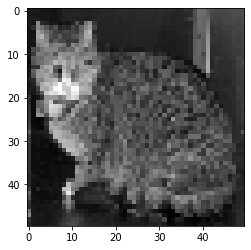

[1. 0.]
22452
2494


In [ ]:
training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))
import matplotlib.pyplot as plt

plt.imshow(training_data[1][0], cmap="gray")
plt.show()

print(training_data[1][1])

import torch
import torch.nn as nn
import torch.nn.functional as F

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
#print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))


In [ ]:
from typing import Any

class BasicGRU(nn.Module):
  def __init__(
      self,
      in_size:int,
      hidden_size:int,
      n_layers:int,
      **kwargs: Any
    ) -> None:
    
    super().__init__()
    
    self.num_directions = 1
    self.in_size = in_size
    self.hidden_size = hidden_size
    self.n_layers = n_layers

    self.gru = nn.GRU(in_size, hidden_size, n_layers, batch_first=True, **kwargs)

    #self.h_0 = torch.randn(self.n_layers * self.num_directions, self.batch, self.hidden_size)


  def set_values(self, x):
    self.batch = x.shape[0]

  
  def forward(self, x):
    self.set_values(x)
    self.h_0 = torch.randn(self.n_layers * self.num_directions, self.batch, self.hidden_size)

    x, _ = self.gru(x, self.h_0)
    #print(x[:,-1])
    
    #return F.relu(x[:, -1], inplace=True)
    return x


class GRU_Net(nn.Module):
  def __init__(self):
    super().__init__()
    
    gru_block = BasicGRU

    #x = torch.randn(50, in_size).view(-1, 50, in_size)
    #self.batch = None
    #self.set_batchsize(x)

    self.gru_1 = gru_block(50, 32, 1)
    self.gru_2 = gru_block(32, 32, 1)    
    self.gru_3 = gru_block(64, 32, 1)
    self.gru_4 = gru_block(96, 32, 1)

    x = torch.randn(50, 50).view(-1, 50, 50)
    self._to_linear = None
    self.grus(x)

    #self.fc1 = nn.Linear(self._to_linear, 512)
    #self.fc2 = nn.Linear(512, 2)

    self.fc1 = nn.Linear(self._to_linear, 2)
 
  def set_batchsize(self, x):
    self.batch = x.shape[0]
  
  def grus(self, x):
    x_1 = self.gru_1(x)
    x_2 = self.gru_2(x_1)
    
    x_12 = [x_1, x_2]
    x_12 = torch.cat(x_12, 2)
    
    x_3 = self.gru_3(x_12)

    x_123 = [x_1, x_2, x_3]
    x_123 = torch.cat(x_123, 2)

    x_4 = self.gru_4(x_123)
    


    
    x = F.relu(x_4[:, -1], inplace=True)

    if self._to_linear == None:
      self._to_linear = x[0].shape[0]#*x[0].shape[1]
      #print(x[0].shape)
      #print(self._to_linear)

    return x
  
  def forward(self, x):
    x = self.grus(x)
    x = x.reshape(-1, self._to_linear)
    #x = F.relu(self.fc1(x))
    #x = self.fc2(x)

    x = self.fc1(x)
  
    return F.softmax(x, dim=1)

gru_net = GRU_Net()

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(gru_net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def fwd_pass(X, y, train=False):
  if train:
    gru_net.zero_grad()
  outputs = gru_net(X)
  matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs, y)]
  acc = matches.count(True)/len(matches)
  loss = loss_function(outputs, y)

  if train:
    loss.backward()
    optimizer.step()
  return acc, loss

import numpy as np

def test(size=32):  
  random_start = np.random.randint(len(test_X) - size)
  X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
  with torch.no_grad():
    val_acc, val_loss = fwd_pass(X.view(-1, 50, 50), y)
  return val_acc, val_loss

val_acc, val_loss = test(size=32)
print(val_acc, val_loss)


import time

MODEL_NAME = f"model-{int(time.time())}"


print(MODEL_NAME)

def train():
  BATCH_SIZE = 132
  EPOCHS = 50

  with open("model.log", "a") as f:
    for epoch in range(EPOCHS):
      for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        acc, loss = fwd_pass(batch_X, batch_y, train=True)
        
        # every 50 steps 
        if i % 50 == 0:
          val_acc, val_loss = test(size=132)
          f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc), 2)}, {round(float(loss), 4)},{round(float(val_acc), 2)}, {round(float(val_loss), 4)}\n")

train()

  1%|          | 1/171 [00:00<00:22,  7.50it/s]

0.4375 tensor(0.2565)
model-1617743108


100%|██████████| 171/171 [00:17<00:00, 10.02it/s]


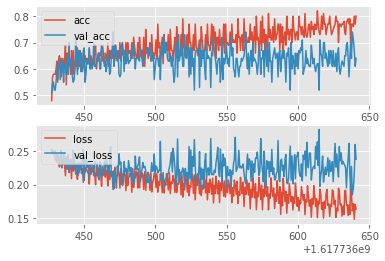

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

def create_acc_loss_graph(model_name):
  contents = open("model.log", "r").read().split('\n')

  times = []
  accs = []
  losses = []

  val_accs = []
  val_losses = []

  for c in contents:
    if model_name in c:      
      name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
      times.append(float(timestamp))
      accs.append(float(acc))
      losses.append(float(loss))
      val_accs.append(float(val_acc))
      val_losses.append(float(val_loss))


  fig = plt.figure()

  ax1 = plt.subplot2grid((2,1),(0,0))
  ax2 = plt.subplot2grid((2,1),(1,0), sharex=ax1)

  ax1.plot(times, accs, label="acc")
  ax1.plot(times, val_accs, label="val_acc")
  ax1.legend(loc=2)

  ax2.plot(times, losses, label="loss")
  ax2.plot(times, val_losses, label="val_loss")
  ax2.legend(loc=2)

  plt.show()

create_acc_loss_graph(MODEL_NAME)
      
      


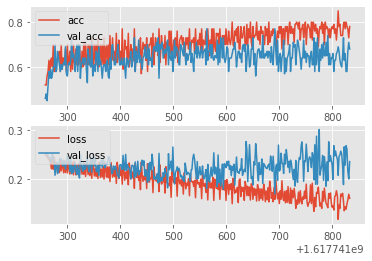

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

def create_acc_loss_graph(model_name):
  contents = open("model.log", "r").read().split('\n')

  times = []
  accs = []
  losses = []

  val_accs = []
  val_losses = []

  for c in contents:
    if model_name in c:      
      name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
      times.append(float(timestamp))
      accs.append(float(acc))
      losses.append(float(loss))
      val_accs.append(float(val_acc))
      val_losses.append(float(val_loss))


  fig = plt.figure()

  ax1 = plt.subplot2grid((2,1),(0,0))
  ax2 = plt.subplot2grid((2,1),(1,0), sharex=ax1)

  ax1.plot(times, accs, label="acc")
  ax1.plot(times, val_accs, label="val_acc")
  ax1.legend(loc=2)

  ax2.plot(times, losses, label="loss")
  ax2.plot(times, val_losses, label="val_loss")
  ax2.legend(loc=2)

  plt.show()

create_acc_loss_graph(MODEL_NAME)
      
      


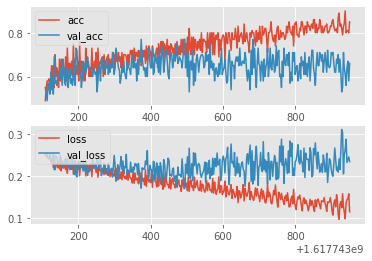

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

def create_acc_loss_graph(model_name):
  contents = open("model.log", "r").read().split('\n')

  times = []
  accs = []
  losses = []

  val_accs = []
  val_losses = []

  for c in contents:
    if model_name in c:      
      name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
      times.append(float(timestamp))
      accs.append(float(acc))
      losses.append(float(loss))
      val_accs.append(float(val_acc))
      val_losses.append(float(val_loss))


  fig = plt.figure()

  ax1 = plt.subplot2grid((2,1),(0,0))
  ax2 = plt.subplot2grid((2,1),(1,0), sharex=ax1)

  ax1.plot(times, accs, label="acc")
  ax1.plot(times, val_accs, label="val_acc")
  ax1.legend(loc=2)

  ax2.plot(times, losses, label="loss")
  ax2.plot(times, val_losses, label="val_loss")
  ax2.legend(loc=2)

  plt.show()

create_acc_loss_graph(MODEL_NAME)
      
      
